In [1]:
import sys

sys.path.append("../")

import pennylane as qml
import pennylane.numpy as np
from main import *

np.random.seed(0)  # For reproducibility

In this notebook we present the syntaxis to create and evaluate quantum states and operators in first quantization in a qubit-based quantum computer.

In the first place let us define the number of qubits and the device to perform the simulations.

In [2]:
num_wires = 3
dev = qml.device("default.qubit", wires=2 * num_wires, shots=100)

Second, we create discrete versions of the position operator $X$ and the momentum operator $P$ between $x_{min}=-5$ and $x_{max}=5$ with the function ```X_and_P_ops``` 

In [3]:
X, P = X_and_P_ops(range(num_wires), x_min=-5, x_max=5)
X, P

(<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>)

We now will evaluate the expected value of those operators in a random quantum state $|\psi\rangle$.

(<Figure size 400x400 with 1 Axes>, <Axes: >)

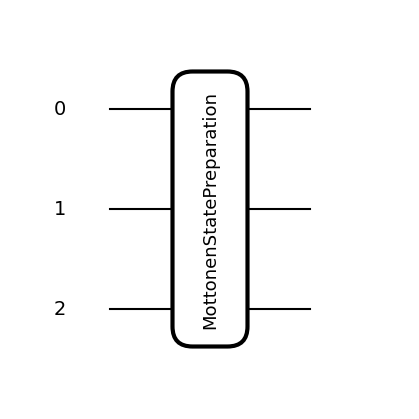

In [4]:
def psi(params):
    qml.MottonenStatePreparation(params, range(num_wires))


params = np.random.randn(2**num_wires) + 1j * np.random.randn(2**num_wires)
params = params / np.linalg.norm(params)

qml.draw_mpl(psi)(params)

We can evaluate the expecting value of $X$ or $P$ over $|\psi\rangle$ creating the corresponding __quantum tape__ with the function ```tapes_XP```.

In [5]:
tape_X = tapes_XP(params, psi, X)
print(tape_X[0].draw())

0: ─╭MottonenStatePreparation(M0)─┤ ╭<None>
1: ─├MottonenStatePreparation(M0)─┤ ├<None>
2: ─╰MottonenStatePreparation(M0)─┤ ╰<None>
M0 = 
[ 0.28530325-0.04397715j  0.07694309-0.44763735j  0.0180054 -0.02227781j
  0.01855989+0.34732534j -0.36141434+0.28594337j  0.38625109-0.09122111j
 -0.07404348+0.31015767j -0.03381837-0.34036708j]


The expected value is given by the function ```exp_val_XP```.

In [6]:
exp_val_XP(circuit_tapes=tape_X, device=dev)

0.19572220008169636

We can also directly give the arguments of ```tapes_XP``` to ```exp_val_XP``` and the device

In [7]:
exp_val_XP(params, psi, X, dev)

0.19572220008169636

For the evaluation of $P$, the tape includes the Fourier Transfom to change the basis from the eigenbasis of $X$ to the eigenbasis of $P$.

In [8]:
tape_P = tapes_XP(params, psi, P)
print(tape_P[0].draw())

0: ─╭MottonenStatePreparation(M0)──H─╭●──╭●────────────┤ ╭<None>
1: ─├MottonenStatePreparation(M0)────╰Rϕ─│────H─╭●─────┤ ├<None>
2: ─╰MottonenStatePreparation(M0)────────╰Rϕ────╰Rϕ──H─┤ ╰<None>
M0 = 
[ 0.28530325-0.04397715j  0.07694309-0.44763735j  0.0180054 -0.02227781j
  0.01855989+0.34732534j -0.36141434+0.28594337j  0.38625109-0.09122111j
 -0.07404348+0.31015767j -0.03381837-0.34036708j]


In [9]:
exp_val_XP(circuit_tapes=tape_P, device=dev)

-0.8975440943344881

Setting the input ```semiclassical=True``` of ```X_and_P_ops```, the evaluation of $P$ is performed with a semiclassical implementation of the Fourier transform. This replaces the controlled operations with mid-circuit measurements and classical controls, thus reducing the depth of the quantum circuit.

In [10]:
X, P = X_and_P_ops(range(num_wires), -5, 5, semiclassical=True)
tape_P = tapes_XP(params, psi, P)
print(tape_P[0].draw())

0: ─╭MottonenStatePreparation(M0)──H──┤↗├─────────────────────┤ ╭<None>
1: ─├MottonenStatePreparation(M0)──────║───Rϕ──H───┤↗├────────┤ ├<None>
2: ─╰MottonenStatePreparation(M0)──────║───║───Rϕ───║───Rϕ──H─┤ ╰<None>
                                       ╚═══╩═══╝    ║   ║              
                                                    ╚═══╝              
M0 = 
[ 0.28530325-0.04397715j  0.07694309-0.44763735j  0.0180054 -0.02227781j
  0.01855989+0.34732534j -0.36141434+0.28594337j  0.38625109-0.09122111j
 -0.07404348+0.31015767j -0.03381837-0.34036708j]


We show a better plot of the Fourier Transform from our implementation of the operation `QFT`, in the standard manner (```semi_classical=False```)

(<Figure size 900x400 with 1 Axes>, <Axes: >)

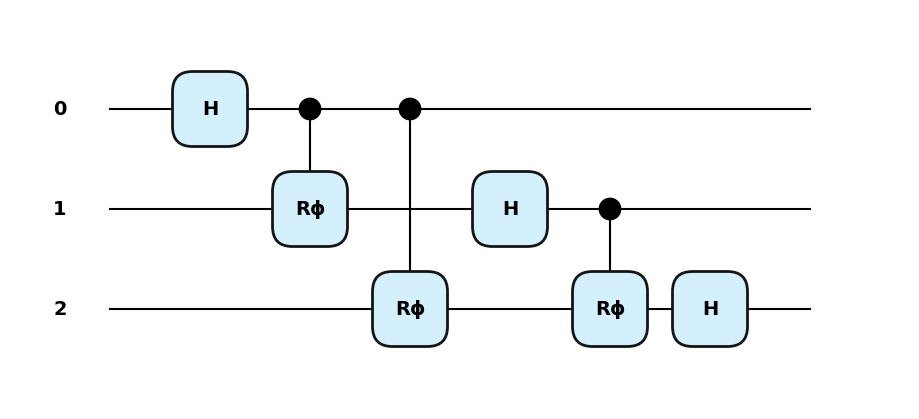

In [11]:
qft = QFT(range(num_wires), semi_classical=False)


def fun():
    qft.decomposition()


qml.draw_mpl(fun, style="pennylane")()

and using the semiclassical variation

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

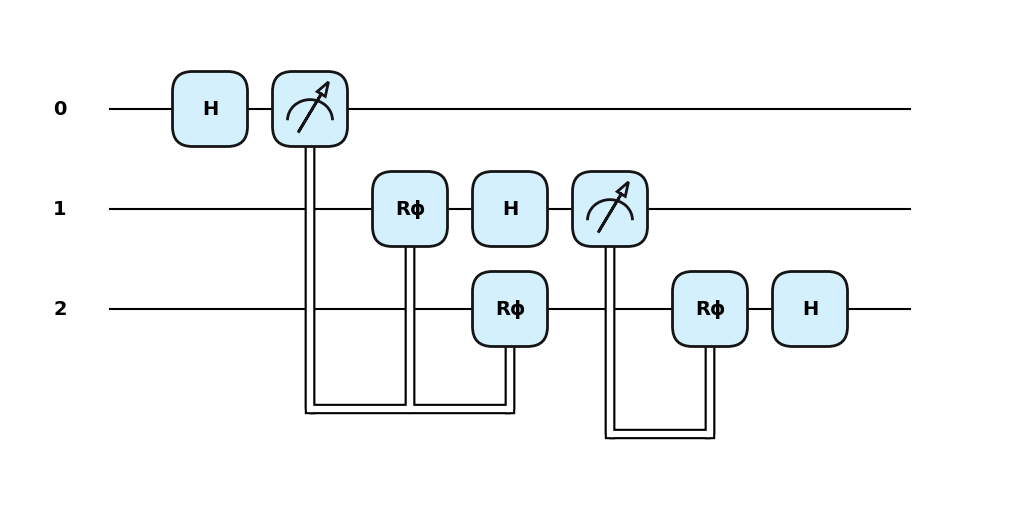

In [12]:
qft = QFT(range(num_wires), semi_classical=True)


def fun():
    qft.decomposition()


qml.draw_mpl(fun, style="pennylane")()

This circuits gives the same expectied value than the standard implementation.

In [13]:
exp_val_XP(circuit_tapes=tape_P, device=dev)

-0.8975440943344881

We can also evaluate arbitrary quadrature operator $Q=aX+bP$ puting each term of the sum in a ```list```.

In [14]:
a = 1
b = 1

Q = [X.s_prod(a), P.s_prod(b)]
Q

[<Hamiltonian: terms=1, wires=[0, 1, 2]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2]>]

In this case the program perform a simulation for each term in the list.

In [15]:
exp_val_XP(params, psi, Q, dev)

-0.7018218942527917

Note that function ```exp_val_XP``` is differentiable, resulting convenient for expectation value optimization.

In [16]:
qml.grad(exp_val_XP)(params, psi, Q, dev)

tensor([-2.27390628+0.19300975j, -0.40571943-2.7037936j ,
        -0.66346885+0.14579812j, -0.61317335+0.18041343j,
         0.03572821-0.7395413j ,  1.47332606-0.53582554j,
         0.01644312-1.16722994j, -0.36029387+2.56428994j], requires_grad=True)